In [1]:
import sys; sys.path.append("..") 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.utility import *
from src.dataprocessing import *
from src import rnn

# Data

## load data

In [2]:
# Define variables
input_var   = ["FT-3061-2", "FT-3061-3", "FT-3061-4", "FT-3062-1"]
output_var  = ["TT-3061-3", "TT-3061-5", "LT-3061-2"]
process_var = input_var + output_var

In [3]:
min_len = 100
continuous_path = './data/3_continuous'

cts_list = []
i = 1
while exists(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv'):
    cts_df = loadfile(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv')
    cts_list.append(cts_df)
    i += 1

csv file is loaded from ./data/3_continuous/cts_100/dataset 100_1.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_2.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_3.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_4.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_5.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_6.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_7.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_8.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_9.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_10.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_11.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_12.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_13.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_14.csv
csv file is loa

## data to series

In [4]:
target_list = cts_list

history_size = 30
future_size = 10
step = 1

history_var = process_var
future_var = output_var

history_num = len(history_var)
future_num = len(future_var)

history_series = []
future_series = []

for i in range(len(target_list)):
    history, future = data2series(target_list[i], history_size, history_var, future_size, future_var,
                                  step, start_idx=0, end_idx=None)
    if not i:
        history_series = history
        future_series = future
    else:
        history_series = np.concatenate([history_series, history], axis=0)
        future_series = np.concatenate([future_series, future], axis=0)

print(history_series.shape)
print(future_series.shape)

(30484, 30, 7)
(30484, 10, 3)


## supervised attention

delta 1


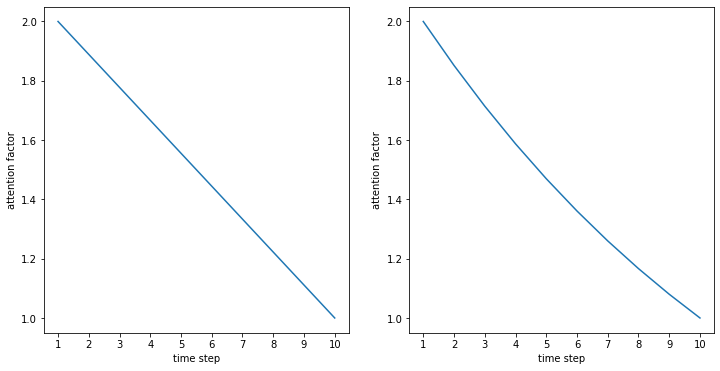

delta 5


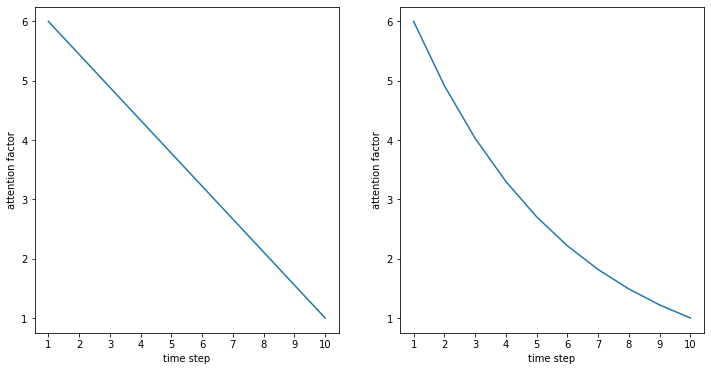

delta 10


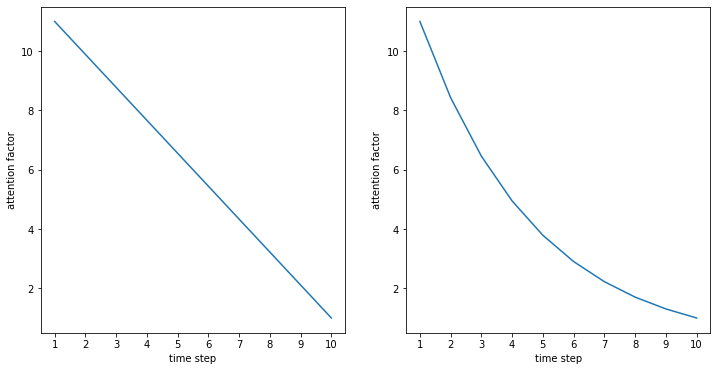

In [5]:
delta_list = [1,5,10]
for delta in delta_list:
    linear_attention = rnn.super_attention(delta, future_size, future_num, 'linear')
    exp_attention = rnn.super_attention(delta, future_size, future_num, 'exp')
    
    print(f"delta {delta}")
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.plot([x for x in range(1,future_size+1)], linear_attention[0,:,0])
    plt.xlabel("time step")
    plt.xticks([x for x in range(1,future_size+1)])
    plt.ylabel("attention factor")
    
    plt.subplot(1,2,2)
    plt.plot([x for x in range(1,future_size+1)], exp_attention[0,:,0])
    plt.xlabel("time step")
    plt.xticks([x for x in range(1,future_size+1)])
    plt.ylabel("attention factor")
    
    plt.show()

# Build model

In [ ]:
Update = False

## seq2seq model

### setting

In [6]:
# supervised attention factor 생성
delta = 1
att_type = 'linear'
factor = rnn.super_attention(delta, future_size, future_num, att_type)

# RNN class 생성
seq2seq_GRU = rnn.RNN(history_series, history_var, future_series, future_var)

# 테스트 데이터 스플릿
test_size = 0.2
test_num = -1
seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

# 검증 데이터 스플릿
valid_size = seq2seq_GRU.history_test.shape[0]/seq2seq_GRU.history_train.shape[0]
seq2seq_GRU.train_valid(valid_size=valid_size)

# 데이터 스케일링
seq2seq_GRU.scaling()

# 모델 구성
num_layers = 1
num_neurons = 50
dense_layers = 1
dense_neurons = 50
model_type = 'seq2seq_gru'
seq2seq_GRU.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type)
print(seq2seq_GRU.model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 50),         8850        ['input_1[0][0]']                
                                 (None, 50)]                                                      
                                                                                                  
 repeat_vector (RepeatVector)   (None, 10, 50)       0           ['encoder[0][0]']                
                                                                                                  
 decoder (GRU)                  (None, 10, 50)       15300       ['repeat_vector[0][0]',      

In [18]:
model_num = 'test'
model_name = f"{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{model_num}"
update = False

if not exists("./model", model_name, 'model') or update or Update:
    seq2seq_GRU.train(epochs=1)
    seq2seq_GRU.save_model(f"./model/{model_name}")
else:
    seq2seq_GRU.model = loadfile("./model", model_name, 'model')

572/572 - 7s - loss: 0.0148 - val_loss: 0.0199 - 7s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ./model/1_50_1_50_seq2seq_gru_test\assets


INFO:tensorflow:Assets written to: ./model/1_50_1_50_seq2seq_gru_test\assets


### result

In [19]:
_ = seq2seq_GRU.test()

,TT-3061-3,TT-3061-5,LT-3061-2,mean,TT-3061-3,TT-3061-5,LT-3061-2,mean
index,R2,R2,R2,R2,nRMSE,nRMSE,nRMSE,nRMSE
0,0.927148,0.910909,0.934153,0.92407,4.380708,5.243019,3.962689,4.528805
1,0.823751,0.848695,0.902831,0.858426,6.76852,6.833536,4.81294,6.138332
2,0.709839,0.803838,0.849773,0.787817,8.56416,7.781562,5.983949,7.443224
3,0.587857,0.777199,0.801131,0.722062,10.06927,8.294201,6.884962,8.416145
4,0.471393,0.755424,0.770833,0.665883,11.290383,8.691198,7.390642,9.124074
5,0.362191,0.734608,0.751074,0.615958,12.281875,9.05489,7.702719,9.679828
6,0.261564,0.713059,0.727518,0.56738,13.090329,9.415994,8.059319,10.188547
7,0.170805,0.691404,0.693211,0.518473,13.840969,9.765099,8.5524,10.719489
8,0.094469,0.670274,0.649789,0.471511,14.484358,10.09416,9.138231,11.238916


### prediction plot

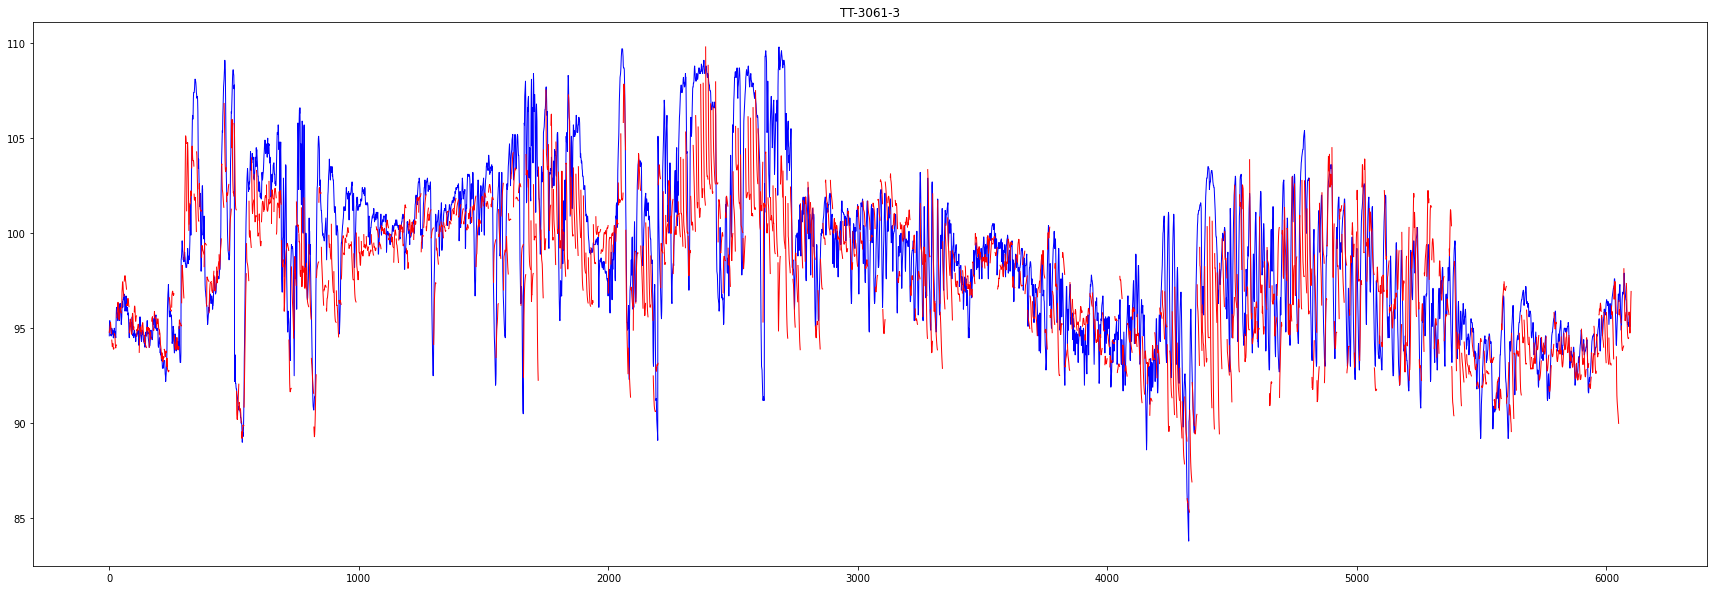

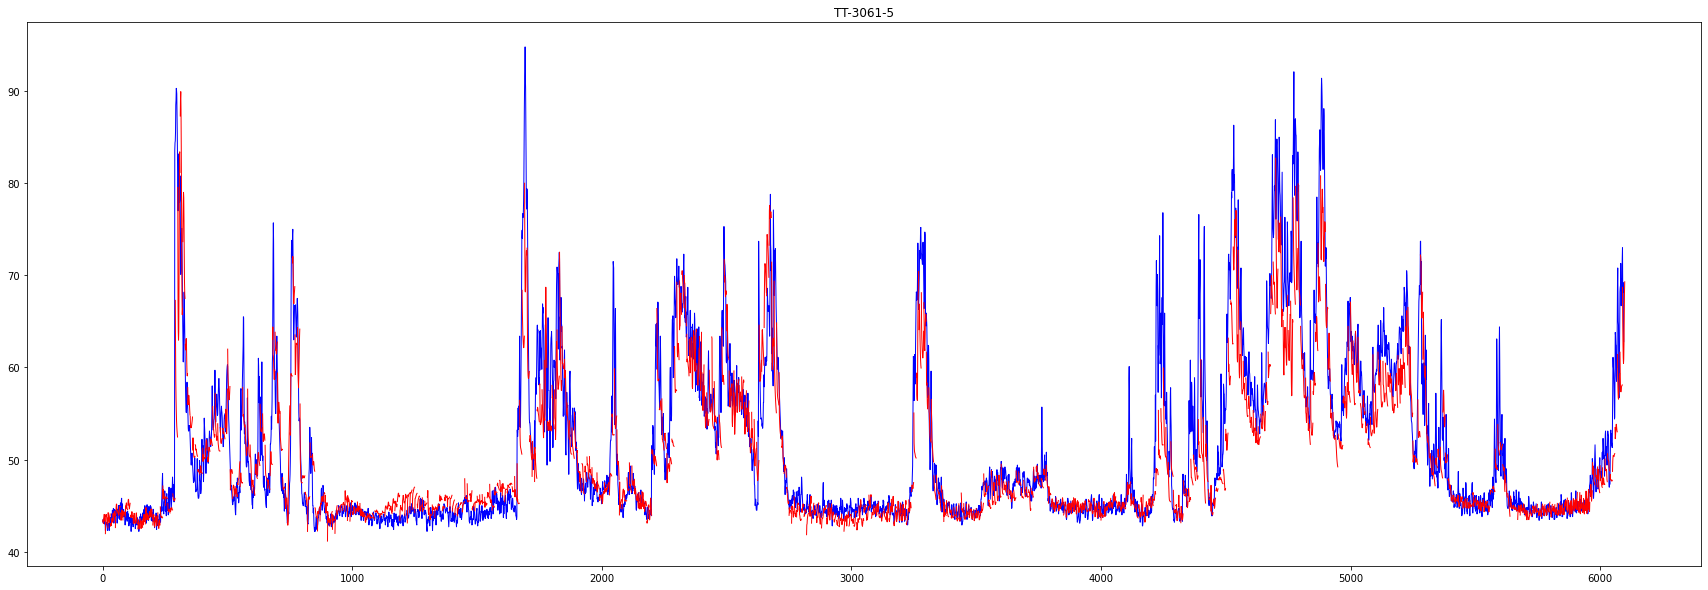

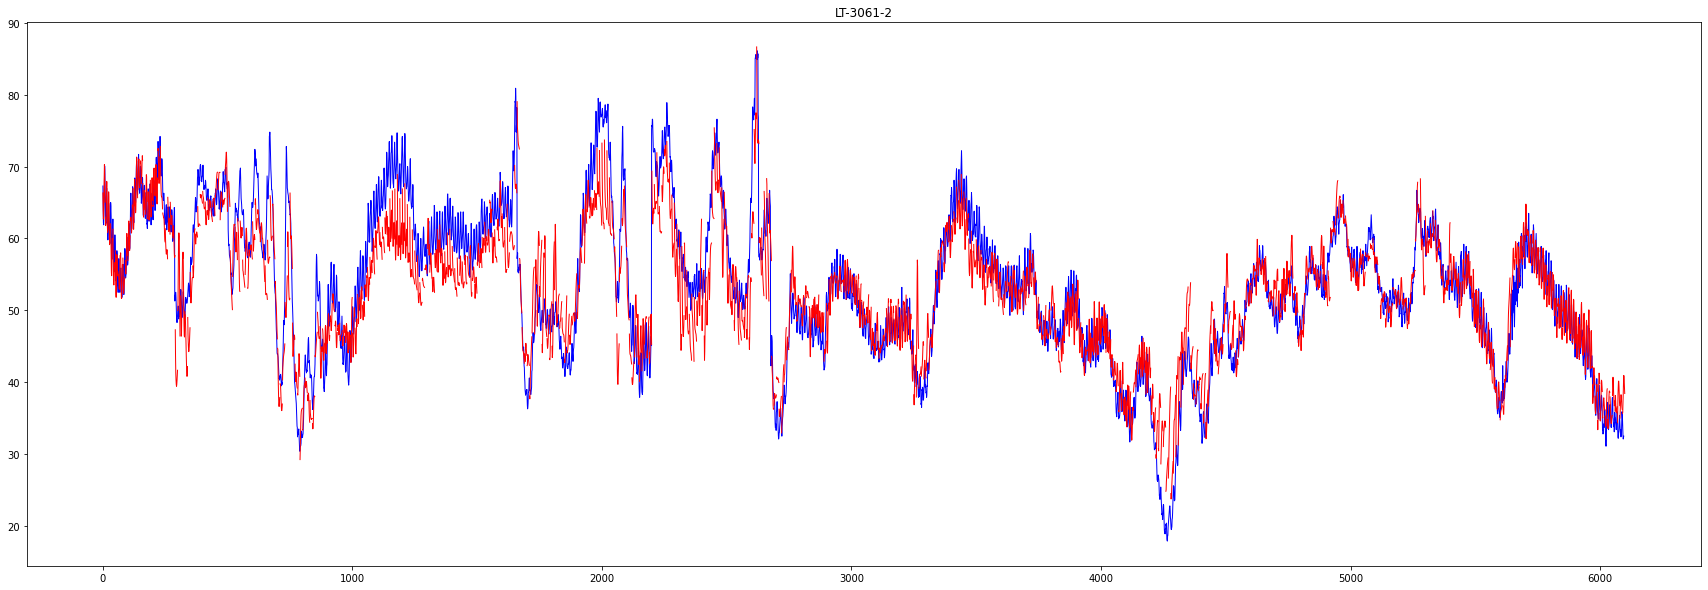

In [ ]:
for var_num in range(len(future_var)):
    predict_sc = seq2seq_GRU.model.predict(seq2seq_GRU.history_test_sc)
    actual_sc = seq2seq_GRU.future_test_sc
    _, predict = seq2seq_GRU.unscaling(seq2seq_GRU.history_test_sc, predict_sc)
    _, actual = seq2seq_GRU.unscaling(seq2seq_GRU.history_test_sc, actual_sc)

    plt.figure(figsize=(30,10))
    plt.plot(np.arange(0,len(actual)), actual[:,0,var_num], label='actual', linewidth=1, color='b')

    for start_idx in range(0, len(predict), future_size):
        end_idx = start_idx + future_size
        predict_plot = predict[start_idx, :, var_num]
        plt.plot(np.arange(start_idx, start_idx + len(predict_plot)), predict_plot, label='prediction', linewidth=1, color='r')
    plt.title(f'{future_var[var_num]}')
    plt.show()
    

## attention model

### setting

In [ ]:
# supervised attention factor 생성
delta = 1
att_type = 'linear'
factor = rnn.super_attention(delta, future_size, future_num, att_type)

# RNN class 생성
ATT_seq2seq_GRU = rnn.RNN(history_series, history_var, future_series, future_var)

# 테스트 데이터 스플릿
test_size = 0.2
test_num = -1
ATT_seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

# 검증 데이터 스플릿
valid_size = ATT_seq2seq_GRU.history_test.shape[0]/ATT_seq2seq_GRU.history_train.shape[0]
ATT_seq2seq_GRU.train_valid(valid_size=valid_size)

# 데이터 스케일링
ATT_seq2seq_GRU.scaling()

# 모델 구성
num_layers = 1
num_neurons = 50
dense_layers = 1
dense_neurons = 50
model_type = 'att_seq2seq_gru'
ATT_seq2seq_GRU.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type, factor=factor)
print(ATT_seq2seq_GRU.model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 30, 50),     8850        ['input_2[0][0]']                
                                 (None, 50)]                                                      
                                                                                                  
 repeat_vector_1 (RepeatVector)  (None, 10, 50)      0           ['encoder[0][1]']                
                                                                                                  
 decoder (GRU)                  (None, 10, 50)       15300       ['repeat_vector_1[0][0]',  

In [ ]:
model_num = 'test'
model_name = f"{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{model_num}"

if not exists("./model", model_name, 'model'):
    ATT_seq2seq_GRU.train(epochs=1)
    ATT_seq2seq_GRU.save_model(f"./model/{model_name}")
else:
    ATT_seq2seq_GRU.model = loadfile("./model", model_name, 'model')

Epoch 1/10000
572/572 - 7s - loss: 0.1062 - val_loss: 0.0779 - 7s/epoch - 13ms/step
Epoch 2/10000
572/572 - 5s - loss: 0.0744 - val_loss: 0.0692 - 5s/epoch - 8ms/step
Epoch 3/10000
572/572 - 5s - loss: 0.0686 - val_loss: 0.0651 - 5s/epoch - 8ms/step
Epoch 4/10000
572/572 - 5s - loss: 0.0658 - val_loss: 0.0604 - 5s/epoch - 8ms/step
Epoch 5/10000
572/572 - 5s - loss: 0.0619 - val_loss: 0.0588 - 5s/epoch - 8ms/step
Epoch 6/10000
572/572 - 5s - loss: 0.0583 - val_loss: 0.0559 - 5s/epoch - 8ms/step
Epoch 7/10000
572/572 - 5s - loss: 0.0564 - val_loss: 0.0532 - 5s/epoch - 8ms/step
Epoch 8/10000
572/572 - 4s - loss: 0.0526 - val_loss: 0.0543 - 4s/epoch - 8ms/step
Epoch 9/10000
572/572 - 4s - loss: 0.0514 - val_loss: 0.0495 - 4s/epoch - 8ms/step
Epoch 10/10000
572/572 - 4s - loss: 0.0491 - val_loss: 0.0510 - 4s/epoch - 8ms/step
Epoch 11/10000
572/572 - 4s - loss: 0.0461 - val_loss: 0.0490 - 4s/epoch - 8ms/step
Epoch 12/10000
572/572 - 5s - loss: 0.0446 - val_loss: 0.0479 - 5s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ./model/1_50_1_50_att_seq2seq_gru_test\assets


INFO:tensorflow:Assets written to: ./model/1_50_1_50_att_seq2seq_gru_test\assets


### result

In [ ]:
_ = ATT_seq2seq_GRU.test()

,TT-3061-3,TT-3061-5,LT-3061-2,mean,TT-3061-3,TT-3061-5,LT-3061-2,mean
index,R2,R2,R2,R2,nRMSE,nRMSE,nRMSE,nRMSE
0,0.88696,0.929816,0.937488,0.918088,5.456825,4.653538,3.861045,4.657136
1,0.805257,0.863572,0.889121,0.85265,7.114776,6.488891,5.141288,6.248318
2,0.715824,0.812619,0.848965,0.792469,8.475381,7.605403,6.000009,7.360264
3,0.621161,0.776342,0.819557,0.73902,9.65387,8.310142,6.558242,8.174084
4,0.532314,0.750635,0.802024,0.694991,10.619876,8.775879,6.869287,8.755014
5,0.454028,0.731819,0.791227,0.659025,11.363298,9.102345,7.054172,9.173272
6,0.389924,0.712344,0.781878,0.628049,11.898331,9.427722,7.210734,9.512262
7,0.336588,0.690167,0.771562,0.599439,12.380256,9.784644,7.379928,9.848276
8,0.29015,0.66753,0.757488,0.571723,12.824217,10.136081,7.604379,10.188226


### attention score

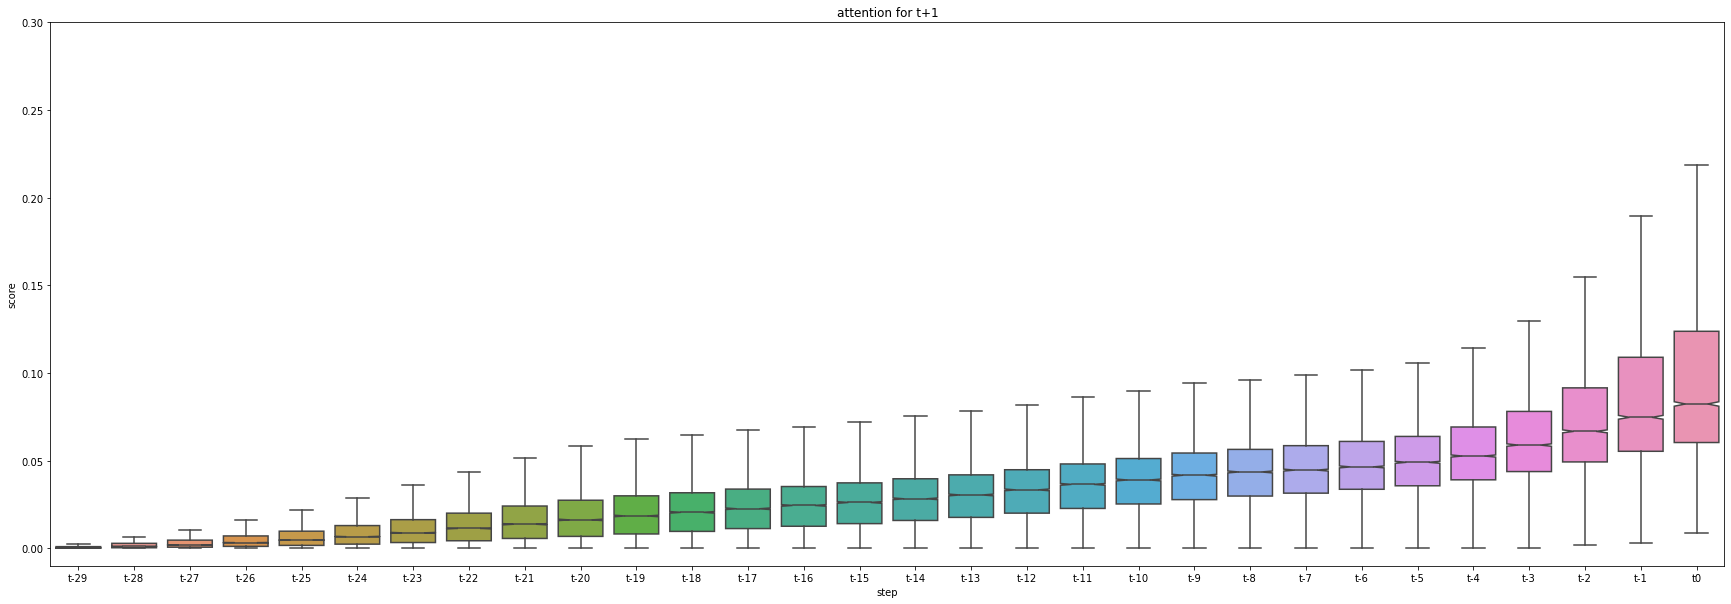

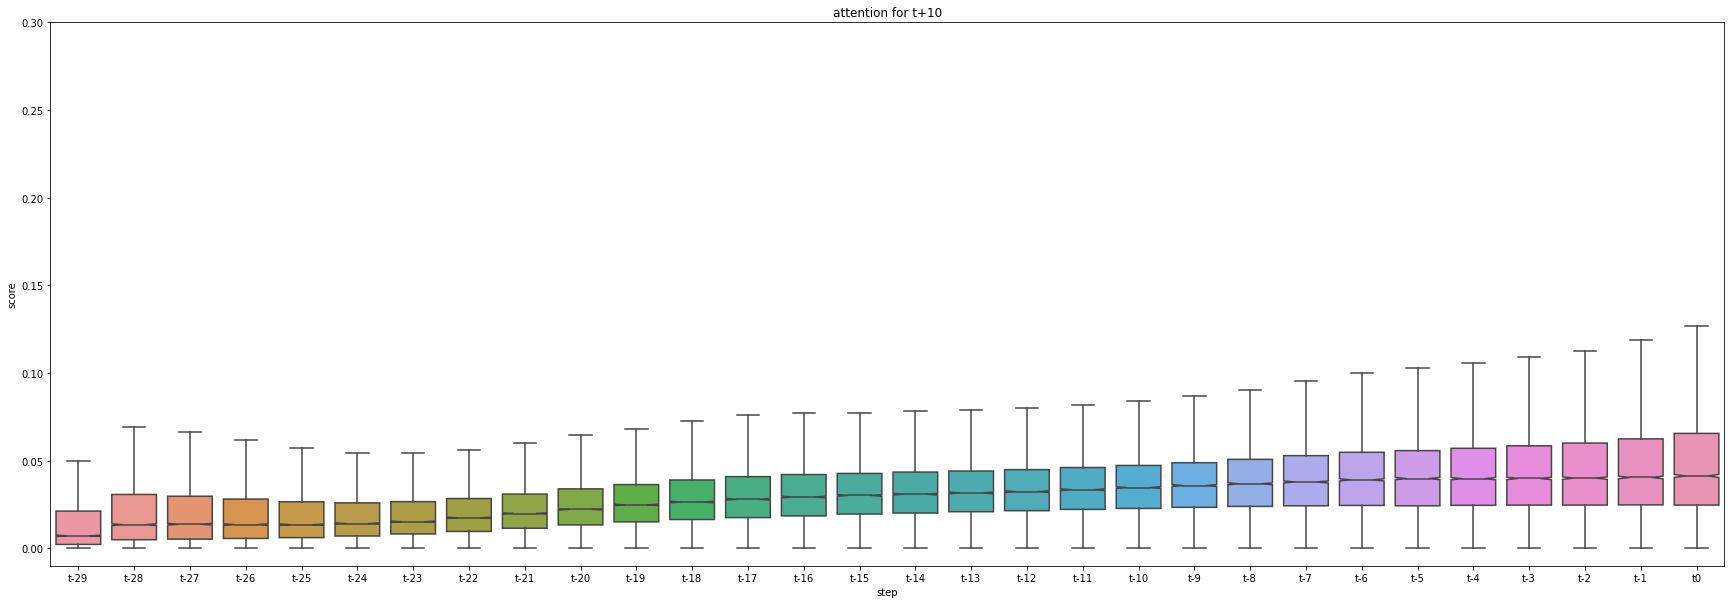

In [ ]:
attention = ATT_seq2seq_GRU.get_attention(ATT_seq2seq_GRU.history_test_sc)
plot_steps = [0, 9]

for future_step in plot_steps:
    attention_step = pd.DataFrame(attention[:,future_step,:], columns=[f't{i-history_size+1}' for i in range(history_size)])

    for i in range(history_size):
        history_step = i-history_size+1
        if not i:
            attention_reshape = attention_step[[f't{history_step}']].copy()
            attention_reshape.columns = ['score']
            attention_reshape['step'] = f't{history_step}'
        else:
            temp = attention_step[[f't{history_step}']].copy()
            temp.columns = ['score']
            temp['step'] = f't{history_step}'        
            attention_reshape = pd.concat([attention_reshape, temp], axis=0)
        attention_reshape.reset_index(drop=True, inplace=True)

    plt.figure(figsize=(30,10))
    sns.boxplot(x='step', y='score', data=attention_reshape, notch=True, showfliers = False)
    plt.ylim(-0.01, 0.3)
    plt.title(f"attention for t+{future_step+1}")
    plt.show()

### prediction plot

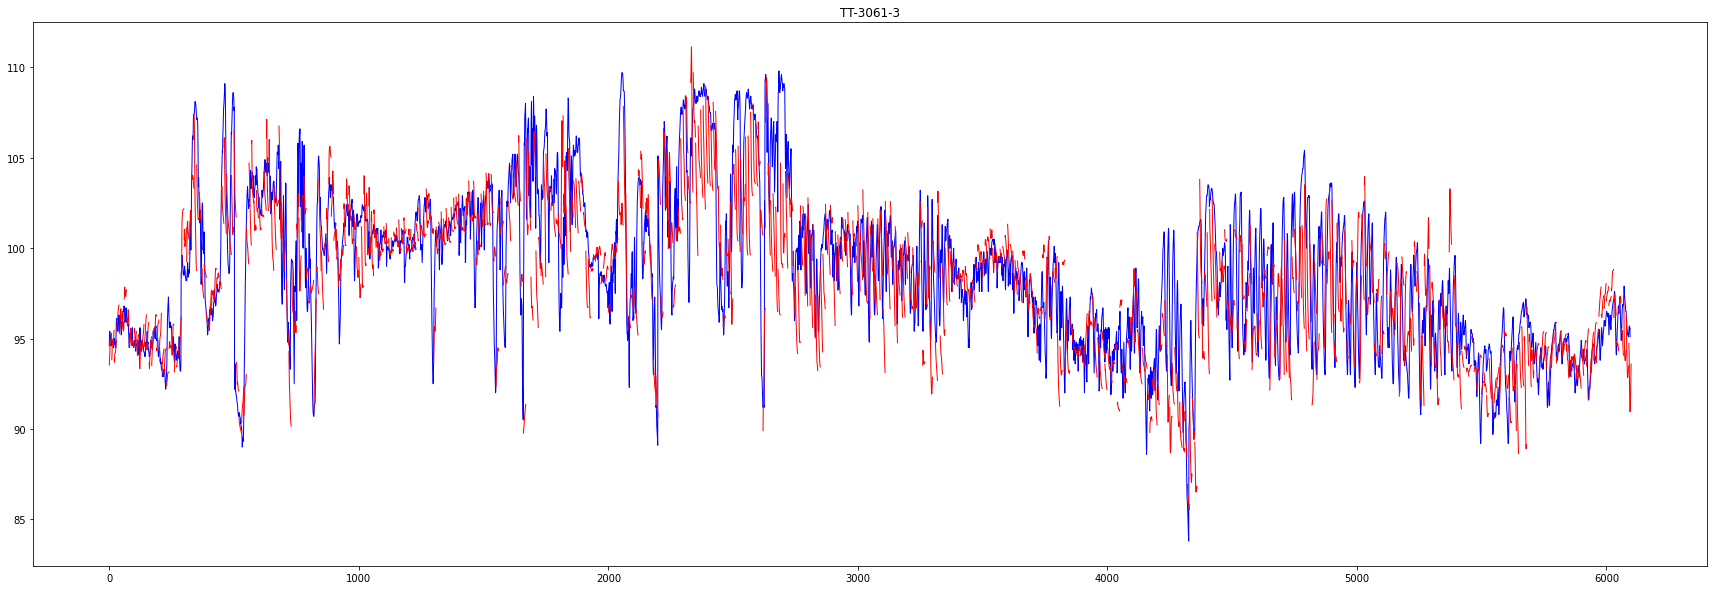

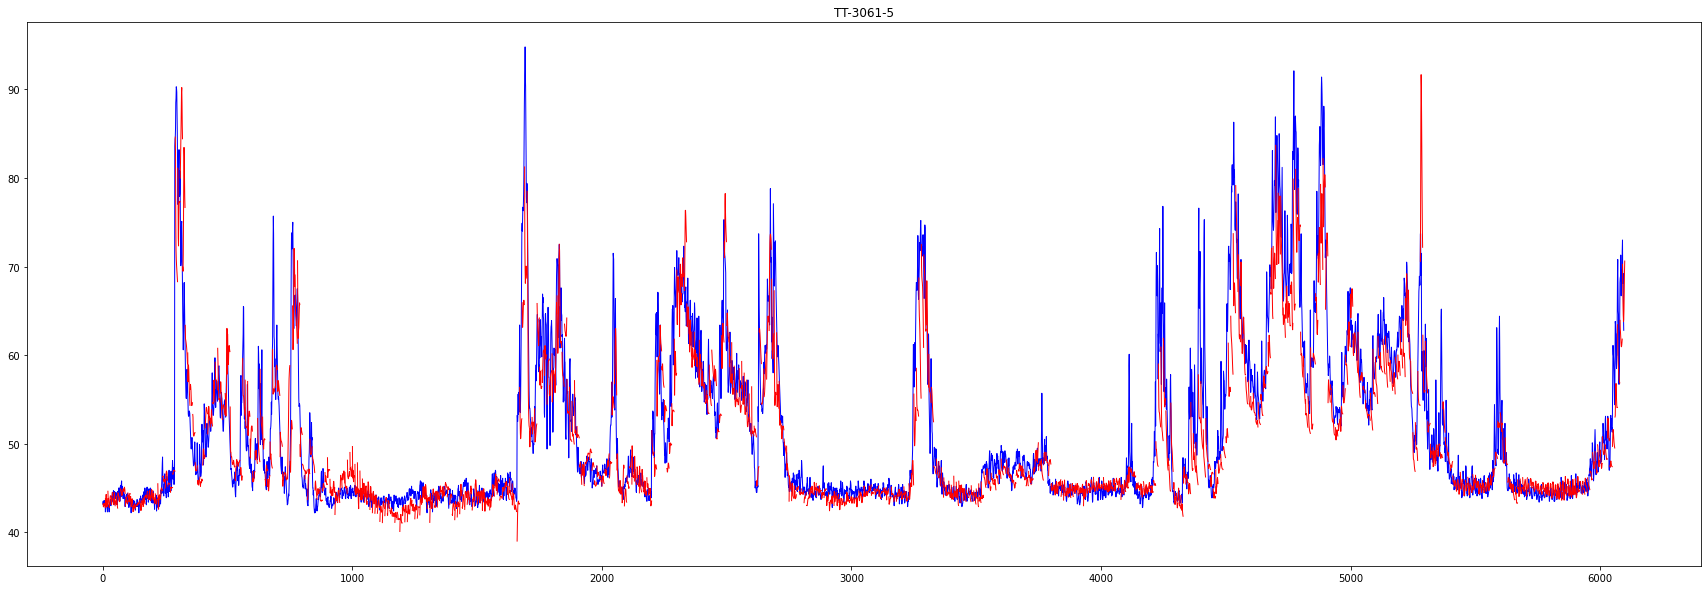

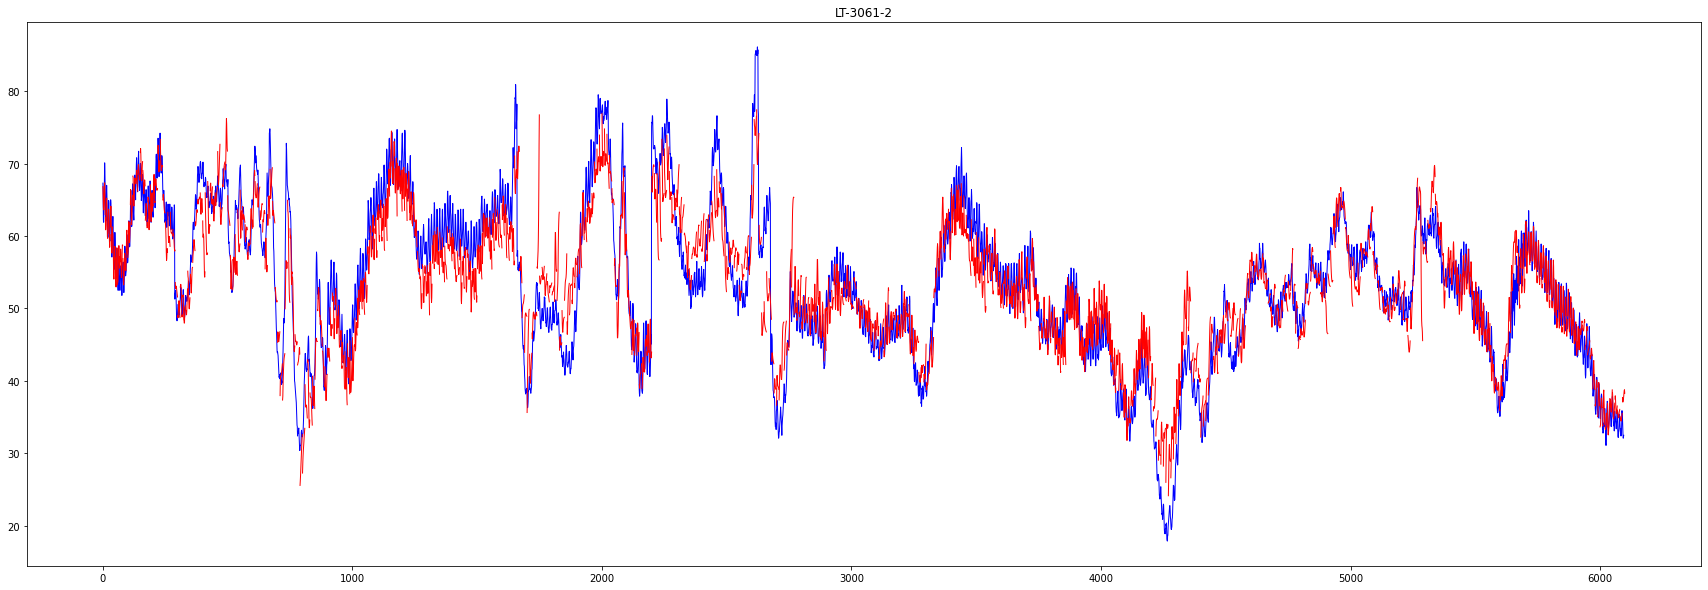

In [ ]:
for var_num in range(len(future_var)):
    predict_sc = ATT_seq2seq_GRU.model.predict(ATT_seq2seq_GRU.history_test_sc)
    actual_sc = ATT_seq2seq_GRU.future_test_sc
    _, predict = ATT_seq2seq_GRU.unscaling(ATT_seq2seq_GRU.history_test_sc, predict_sc)
    _, actual = ATT_seq2seq_GRU.unscaling(ATT_seq2seq_GRU.history_test_sc, actual_sc)

    plt.figure(figsize=(30,10))
    plt.plot(np.arange(0,len(actual)), actual[:,0,var_num], label='actual', linewidth=1, color='b')

    for start_idx in range(0, len(predict), future_size):
        end_idx = start_idx + future_size
        predict_plot = predict[start_idx, :, var_num]
        plt.plot(np.arange(start_idx, start_idx + len(predict_plot)), predict_plot, label='prediction', linewidth=1, color='r')
    plt.title(f'{future_var[var_num]}')
    plt.show()

## dual attention model

### setting

In [ ]:
# supervised attention factor 생성
delta = 1
att_type = 'linear'
factor = rnn.super_attention(delta, future_size, future_num, att_type)

# RNN class 생성
DATT_seq2seq_GRU = rnn.RNN(history_series, history_var, future_series, future_var)

# 테스트 데이터 스플릿
test_size = 0.2
test_num = -1
DATT_seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

# 검증 데이터 스플릿
valid_size = DATT_seq2seq_GRU.history_test.shape[0]/DATT_seq2seq_GRU.history_train.shape[0]
DATT_seq2seq_GRU.train_valid(valid_size=valid_size)

# 데이터 스케일링
DATT_seq2seq_GRU.scaling()

# 모델 구성
num_layers = 1
num_neurons = 50
dense_layers = 1
dense_neurons = 50
model_type = 'datt_seq2seq_gru'
DATT_seq2seq_GRU.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type, factor=factor)
print(DATT_seq2seq_GRU.model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30, 7)]      0           []                               
                                                                                                  
 gru (GRU)                      [(None, 30, 50),     8850        ['input_3[0][0]']                
                                 (None, 50)]                                                      
                                                                                                  
 repeat_vector_2 (RepeatVector)  (None, 10, 50)      0           ['gru[0][1]']                    
                                                                                                  
 gru_1 (GRU)                    (None, 10, 50)       15300       ['repeat_vector_2[0][0]',  

In [ ]:
model_num = 'test'
model_name = f"{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{model_num}"
update = True

if not exists("./model", model_name, 'model'):
    DATT_seq2seq_GRU.train(epochs=1)
    DATT_seq2seq_GRU.save_model(f"./model/{model_name}")
else:
    DATT_seq2seq_GRU.model = loadfile("./model", model_name, 'model')

Epoch 1/10000
572/572 - 7s - loss: 0.2502 - val_loss: 0.1546 - 7s/epoch - 13ms/step
Epoch 2/10000
572/572 - 5s - loss: 0.1502 - val_loss: 0.1393 - 5s/epoch - 8ms/step
Epoch 3/10000
572/572 - 5s - loss: 0.1385 - val_loss: 0.1309 - 5s/epoch - 8ms/step
Epoch 4/10000
572/572 - 4s - loss: 0.1273 - val_loss: 0.1189 - 4s/epoch - 8ms/step
Epoch 5/10000
572/572 - 5s - loss: 0.1165 - val_loss: 0.1126 - 5s/epoch - 8ms/step
Epoch 6/10000
572/572 - 4s - loss: 0.1087 - val_loss: 0.1045 - 4s/epoch - 8ms/step
Epoch 7/10000
572/572 - 5s - loss: 0.1036 - val_loss: 0.0993 - 5s/epoch - 8ms/step
Epoch 8/10000
572/572 - 4s - loss: 0.0989 - val_loss: 0.0944 - 4s/epoch - 8ms/step
Epoch 9/10000
572/572 - 4s - loss: 0.0955 - val_loss: 0.0928 - 4s/epoch - 8ms/step
Epoch 10/10000
572/572 - 4s - loss: 0.0933 - val_loss: 0.0896 - 4s/epoch - 8ms/step
Epoch 11/10000
572/572 - 4s - loss: 0.0899 - val_loss: 0.0940 - 4s/epoch - 8ms/step
Epoch 12/10000
572/572 - 4s - loss: 0.0883 - val_loss: 0.0883 - 4s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ./model/1_50_1_50_datt_seq2seq_gru_test\assets


INFO:tensorflow:Assets written to: ./model/1_50_1_50_datt_seq2seq_gru_test\assets


TypeError: Unable to serialize b'I01\n' to JSON. Unrecognized type <class 'bytes'>.

### result

In [ ]:
_ = DATT_seq2seq_GRU.test()

,TT-3061-3,TT-3061-5,LT-3061-2,mean,TT-3061-3,TT-3061-5,LT-3061-2,mean
index,R2,R2,R2,R2,nRMSE,nRMSE,nRMSE,nRMSE
0,0.872082,0.878842,0.918002,0.889642,7.042501,6.141259,4.405256,5.863005
1,0.795011,0.80551,0.869383,0.823301,8.755447,7.782797,5.56104,7.366428
2,0.692965,0.745822,0.835412,0.758067,10.248843,8.8996,6.24342,8.463954
3,0.567596,0.708755,0.812751,0.696368,11.756832,9.529422,6.659918,9.31539
4,0.434884,0.683414,0.798259,0.638852,13.225869,9.939373,6.913464,10.026235
5,0.298859,0.664946,0.786619,0.583475,14.682752,10.229219,7.110628,10.6742
6,0.171559,0.651342,0.775521,0.532808,15.647581,10.436239,7.29387,11.125897
7,0.061398,0.63985,0.761959,0.487735,16.33726,10.60886,7.511341,11.48582
8,-0.035736,0.628726,0.741432,0.444807,16.909668,10.774108,7.828242,11.837339


### attention score

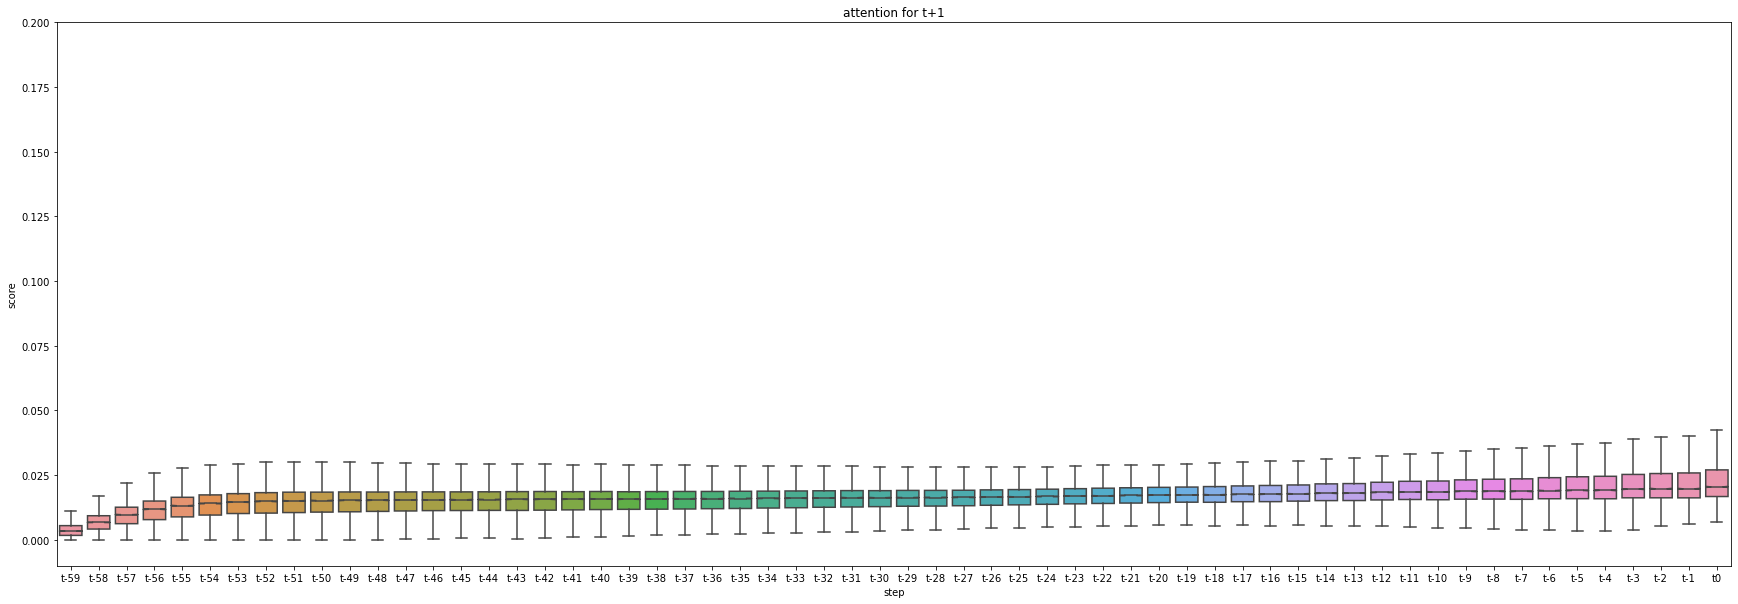

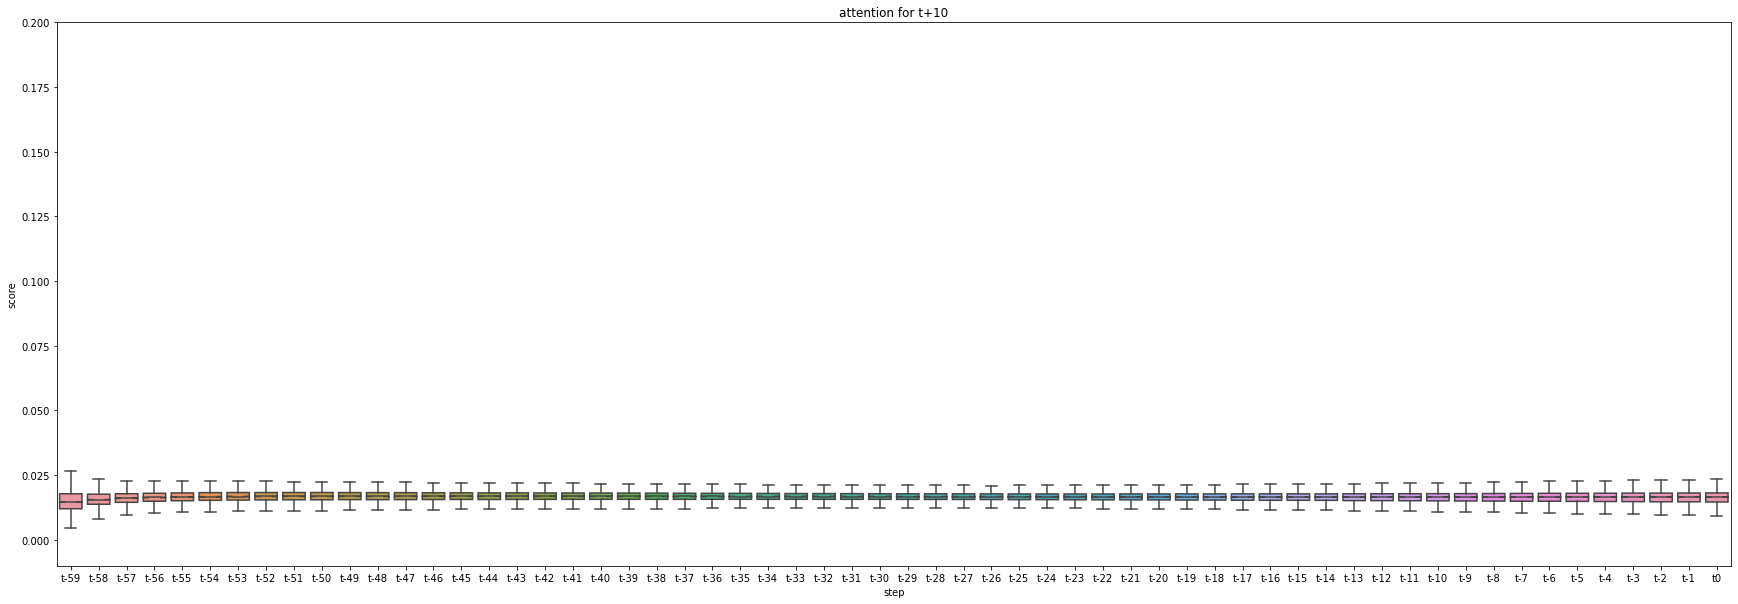

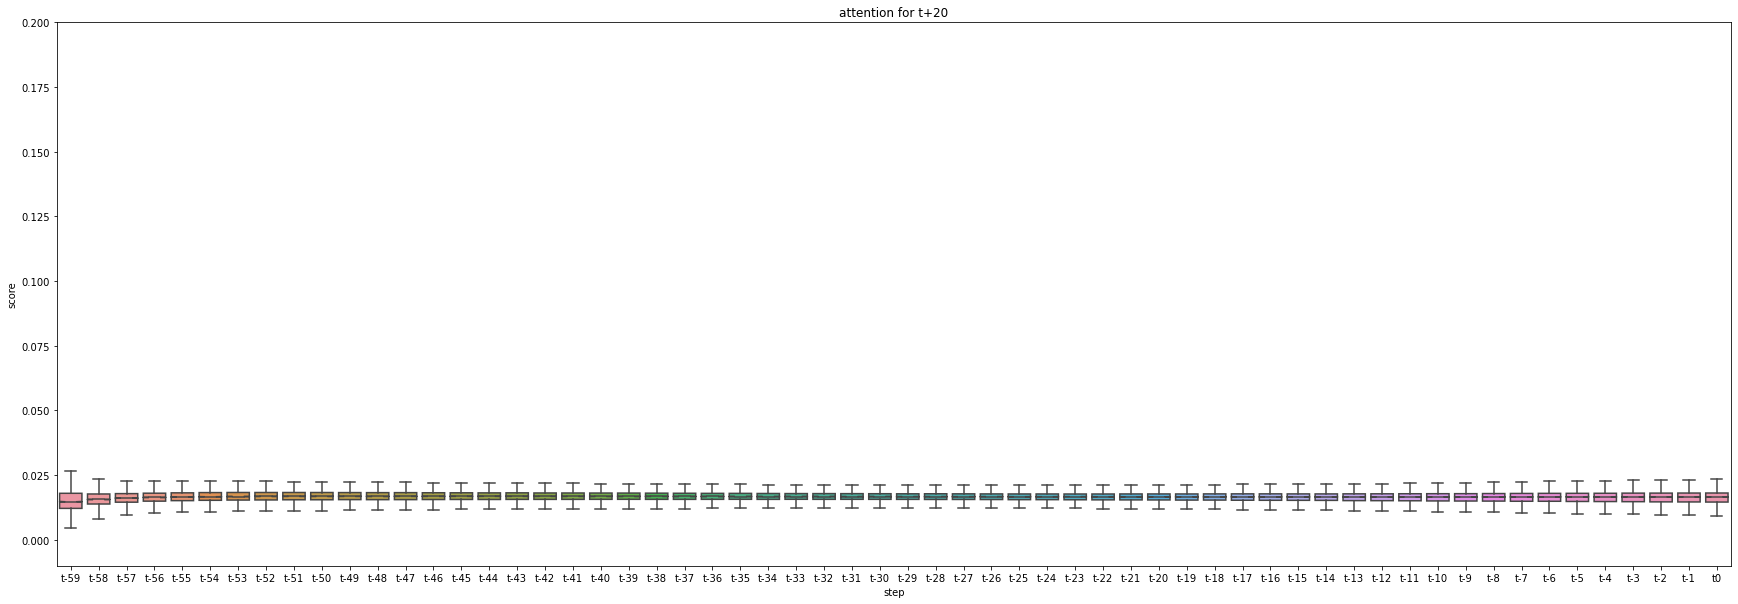

In [ ]:
attention = DATT_seq2seq_GRU.get_attention(DATT_seq2seq_GRU.history_test_sc)
plot_steps = [0,9]

for future_step in plot_steps:
    attention_step = pd.DataFrame(attention[:,future_step,:], columns=[f't{i-history_size+1}' for i in range(history_size)])

    for i in range(history_size):
        history_step = i-history_size+1
        if not i:
            attention_reshape = attention_step[[f't{history_step}']].copy()
            attention_reshape.columns = ['score']
            attention_reshape['step'] = f't{history_step}'
        else:
            temp = attention_step[[f't{history_step}']].copy()
            temp.columns = ['score']
            temp['step'] = f't{history_step}'        
            attention_reshape = pd.concat([attention_reshape, temp], axis=0)
        attention_reshape.reset_index(drop=True, inplace=True)

    plt.figure(figsize=(30,10))
    sns.boxplot(x='step', y='score', data=attention_reshape, notch=True, showfliers = False)
    plt.ylim(-0.01, 0.3)
    plt.title(f"attention for t+{future_step+1}")
    plt.show()

### prediction plot

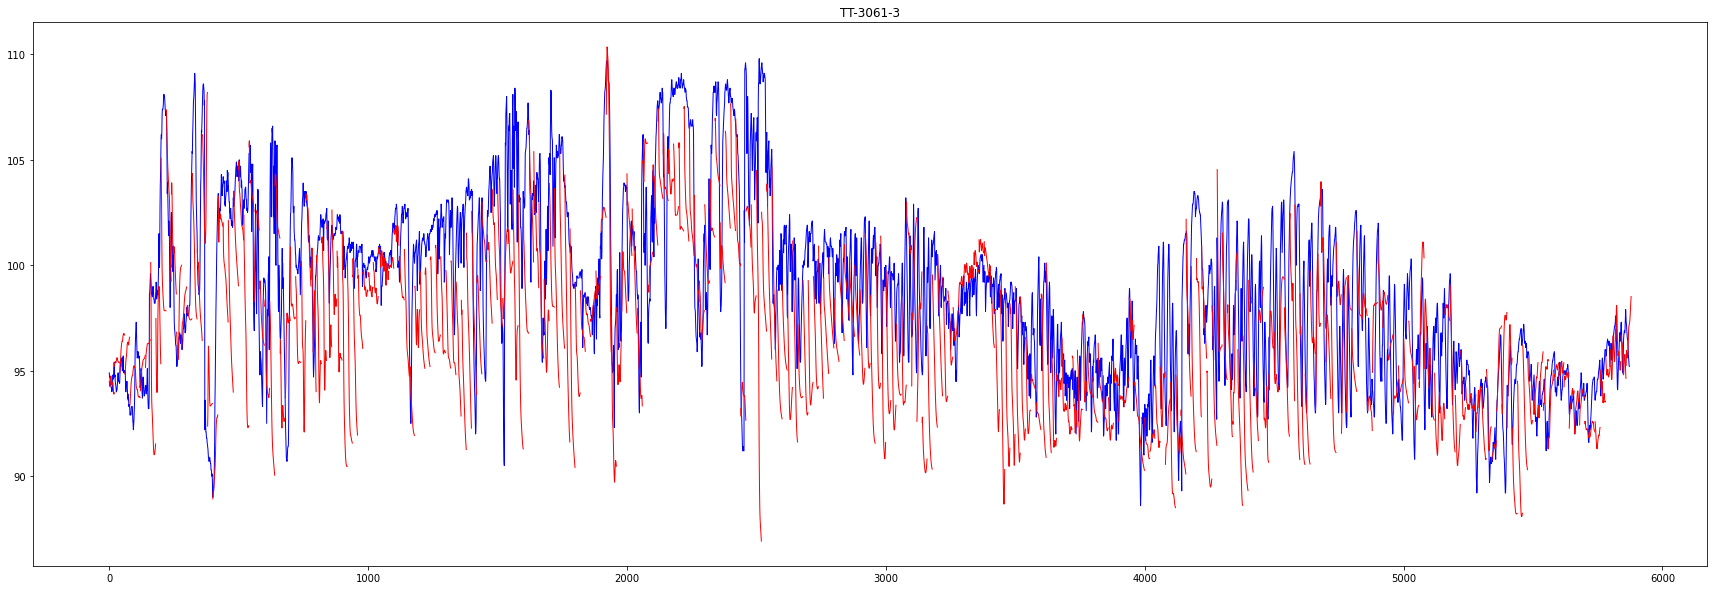

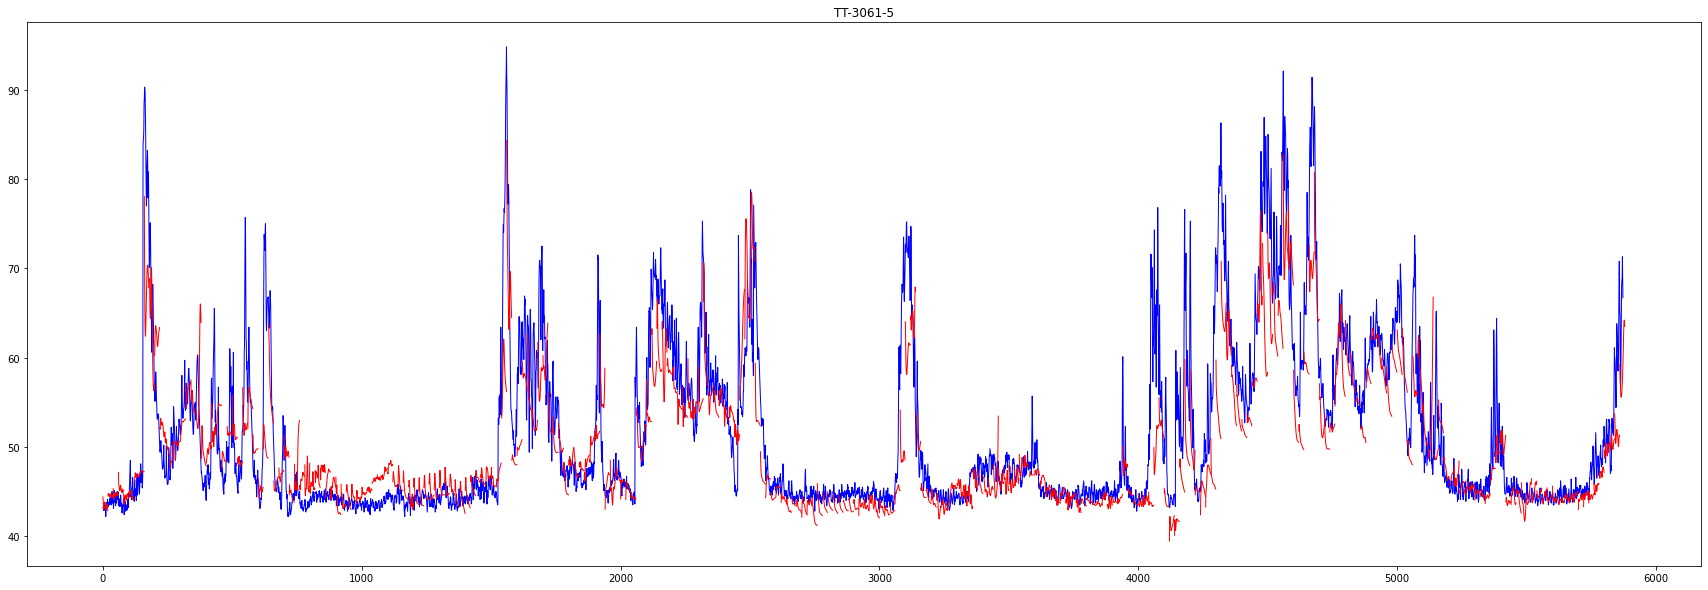

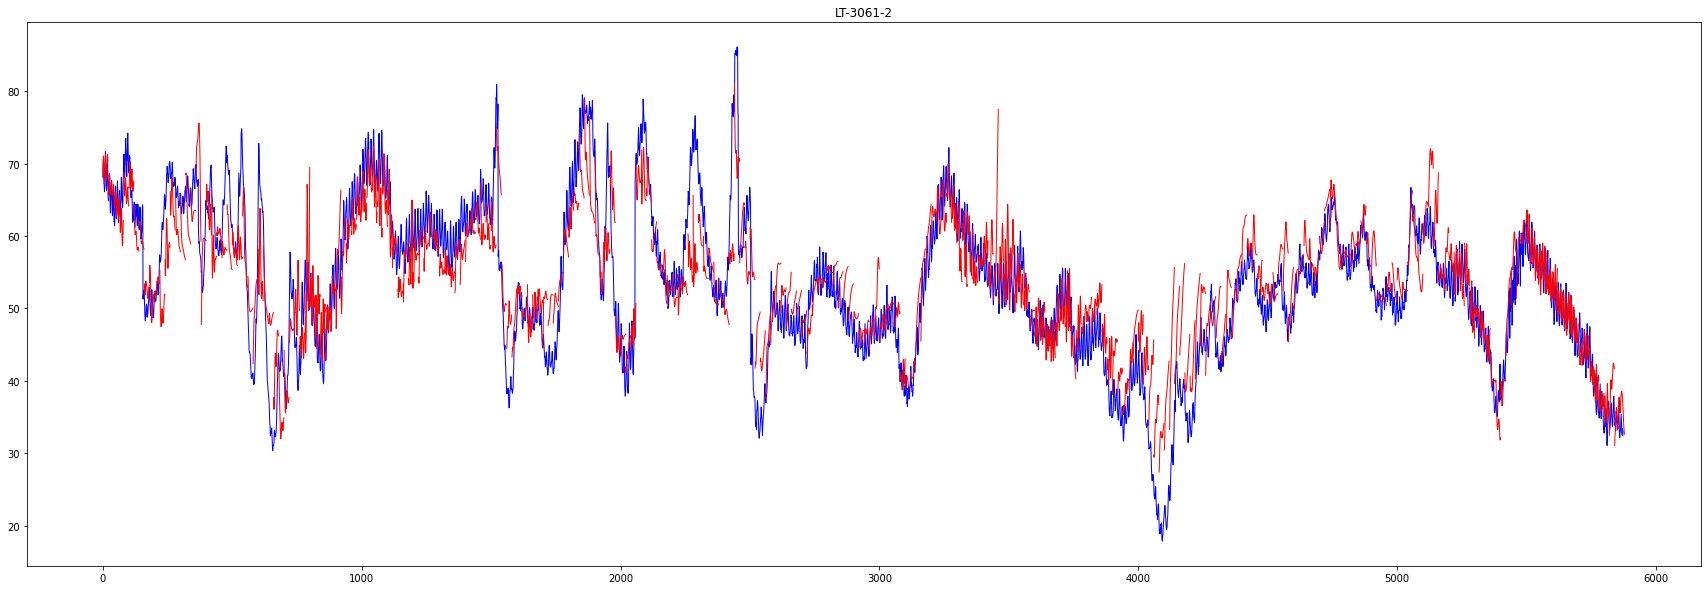

In [ ]:
for var_num in range(len(future_var)):
    predict_wt = DATT_seq2seq_GRU.model.predict(DATT_seq2seq_GRU.history_test_sc)
    predict_sc = predict_wt/DATT_seq2seq_GRU.factor
    actual_sc = DATT_seq2seq_GRU.future_test_sc
    _, predict = DATT_seq2seq_GRU.unscaling(DATT_seq2seq_GRU.history_test_sc, predict_sc)
    _, actual = DATT_seq2seq_GRU.unscaling(DATT_seq2seq_GRU.history_test_sc, actual_sc)

    plt.figure(figsize=(30,10))
    plt.plot(np.arange(0,len(actual)), actual[:,0,var_num], label='actual', linewidth=1, color='b')

    for start_idx in range(0, len(predict), future_size):
        end_idx = start_idx + future_size
        predict_plot = predict[start_idx, :, var_num]
        plt.plot(np.arange(start_idx, start_idx + len(predict_plot)), predict_plot, label='prediction', linewidth=1, color='r')
    plt.title(f'{future_var[var_num]}')
    plt.show()